# Evaluation Metrics & Application to Trading Rules

## Background

Suppose you are working as an analyst at an investment bank. Your manager asked you to implement a decision tree to test one of the desk trader's startegy.

The trader uses 6 indicators to implement a buy or sell strategy for Apple. Your manager did not specify anything else except that you need to implement a decision tree algorithm. 

Here are the indicators you will use:
* Average True Range
* Average Directional Index
* Relative Strength Index
* Binary Indicator when Price is greater than EMA(10)
* Binary Indicator when EMA(10) is greater than EMA(30)
* Binary Indicator when MACD-Signal is greater than MACD

You will train your model between 1981-01-30 and 2020-08-26, and test it on 2021-06-15- 2022-03-30. You will notice that the period between 2020-08-26 and 2021-06-14 is left for validation. We will produce one-step ahead predictions for 200 days starting in 2021-06-15

* Train 1981/01/30 - 2020/08/26
* Validation 2020/08/26 - 2021/06/14
* Test 2021/06/15 - 2022/03/30


## Outline:
1. Demonstrate the various evaluation metrics in sklearn.
2. We use Apple stock data from Yahoo Finance
3. We will build a Classification Model
4. We will visualize the ROC curve


## Importing Libraries

In [ ]:
! pip install pandas_ta
! pip install yfinance

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz
from sklearn import metrics

## Loading Data

We use the YFinance Package to download data directly from Yahoo Finance.

In [ ]:
df= pd.DataFrame()
df=df.ta.ticker('aapl')


## Data Transformation and Technical Analysis

In [ ]:
# Exponential Moving Averages
df['ema10']=ta.ema(df['Close'],length=10)
df['ema30']=ta.ema(df['Close'],length=30)

# Average True Range- Measures Volatility Caused by Price Gaps or Limit Moves
df['atr'] = ta.atr(df['High'],df['Low'],df['Close'])

# Average Directional Movement Index - to  quantify trend strength by measuring 
# the amount of movement in a single direction

adx= ta.adx(df['High'],df['Low'],df['Close'])
df['adx'] = adx['ADX_14']

# Moving Average Convergence/ Divergence
#   Used to identify aspects of a security's overall trend
#   MACD Line: (12-day EMA - 26-day EMA) 
#   Signal Line: 9-day EMA of MACD Line
#   MACD Histogram: MACD Line - Signal Line

macd = macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
df['macd']=macd['MACD_12_26_9']
df['macds']=macd['MACDs_12_26_9']


# Relative Strength Index
#   momentum oscillator used to measure the
#   velocity as well as the magnitude of directional price movements

df['rsi'] =ta.rsi(df['Close'],length=14)

df['Cgtema10'] = np.where(df['Close'] > df['ema10'], 1, -1)
df['ema10gtema30'] = np.where(df['ema10'] > df['ema30'], 1, -1)
df['macdsgtmacd'] = np.where(df['macds'] > df['macd'], 1, -1)

df['Return_1'] = df['Close'].pct_change(1).shift(-1)
df['target'] = np.where(df.Return_1 > 0, 1, 0)

df.dropna(inplace=True)

# Features
predictors_list = ['atr', 'adx','rsi', 'Cgtema10', 'ema10gtema30', 'macdsgtmacd']
X = df[predictors_list]

# Target Variable
y = df.target





In [ ]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ema10,ema30,atr,adx,macd,macds,rsi,Cgtema10,ema10gtema30,macdsgtmacd,Return_1,target
Date,,,,,,,,,,,,,,,,,,,
1981-01-30,0.099451,0.099451,0.098578,0.098578,46188800,0.0,0.0,0.107993,0.108338,0.003337,10.968777,-0.000326,0.001332,36.093559,-1,-1,1,-0.057518,0
1981-02-02,0.093345,0.093345,0.092908,0.092908,23766400,0.0,0.0,0.105250,0.107343,0.003518,13.217224,-0.001535,0.000759,31.277558,-1,-1,1,0.037556,1
1981-02-03,0.096398,0.096834,0.096398,0.096398,19152000,0.0,0.0,0.103641,0.106636,0.003549,14.254503,-0.002186,0.000170,36.860838,-1,-1,1,0.036197,1
1981-02-04,0.099887,0.100323,0.099887,0.099887,27865600,0.0,0.0,0.102958,0.106201,0.003578,14.315045,-0.002393,-0.000343,41.940639,-1,-1,1,0.000000,0
1981-02-05,0.099887,0.100759,0.099887,0.099887,7929600,0.0,0.0,0.102400,0.105794,0.003372,14.264648,-0.002529,-0.000780,41.940639,-1,-1,1,0.004366,1


## Splitting the Data

In [ ]:
X_train=X.loc['1981-01-30':'2020-08-26']
X_valid=X.loc['2020-08-27':'2021-06-14']
X_test=X.loc['2021-06-15':]
y_train=y.loc['1981-01-30':'2020-08-26']
y_valid=y.loc['2020-08-27':'2021-06-14']
y_test=y.loc['2021-06-15':]

## Building The Decision Tree for Trading and testing the fit on the validation set

In [ ]:
for leaf_size in [8,10]:
  for min_samples_split in [8,10]:
    for max_depth in [8,10]:
      
      clf = DecisionTreeClassifier(criterion='entropy',
                                   min_samples_leaf=leaf_size,
                                   min_samples_split=min_samples_split,
                                   max_depth=max_depth, random_state=34)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_valid)
      print ('Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] '+ '=' + '[' +str(leaf_size) +';'+
             str(min_samples_split)+';'+ str(max_depth)+']' + 'is' +' = ' + 
              str(accuracy_score(y_valid, y_pred)) + '\n')


    
 

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[8;8;8]is = 0.475

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[8;8;10]is = 0.51

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[8;10;8]is = 0.475

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[8;10;10]is = 0.51

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[10;8;8]is = 0.465

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[10;8;10]is = 0.49

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[10;10;8]is = 0.465

Validation accuracy where [min_samples_leaf;min_samples_split;max_depth] =[10;10;10]is = 0.49



In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=8,min_samples_split=8,max_depth=10,random_state=34)
clf = clf.fit(X_train, y_train)


## Make Predictions

In [ ]:
pred = clf.predict(X_test)

## Evaluation Metrics

## Accuracy is the number of instances where our prediction is equal to the ground truth over total number of instances

In [ ]:
print ('accuracy for model 1 = ' + str(round(metrics.accuracy_score(y_test, pred),4)))

accuracy for model 1 = 0.5149


## Confusion Matrix is a matrix that is used to describe the performance of the classification model

True Positives (TP): These are cases in which we predicted an increase in stock price (the return is positive), and stock price increased.

True Negatives (TN): We predicted a decrease in stock price, and the stock price decreased.

False Positives (FP): Wepredicted an increase in stock price, but stock price decreased (Also known as a "Type I error.")

False Negatives (FN): We predicted a decrease in stock price, but the stock price increased. (Also known as a "Type II error.")

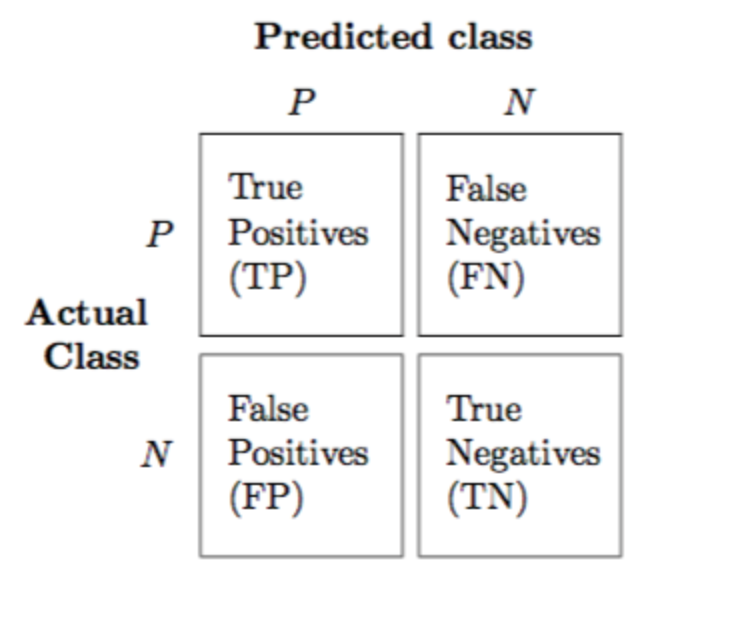

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/Shareddrives/MGTF495/Lectures/Week_2/confusion.png')

In [ ]:
print('The confusion matrix is: \n')
print(metrics.confusion_matrix(y_test, pred))

The confusion matrix is: 

[[37 57]
 [41 67]]


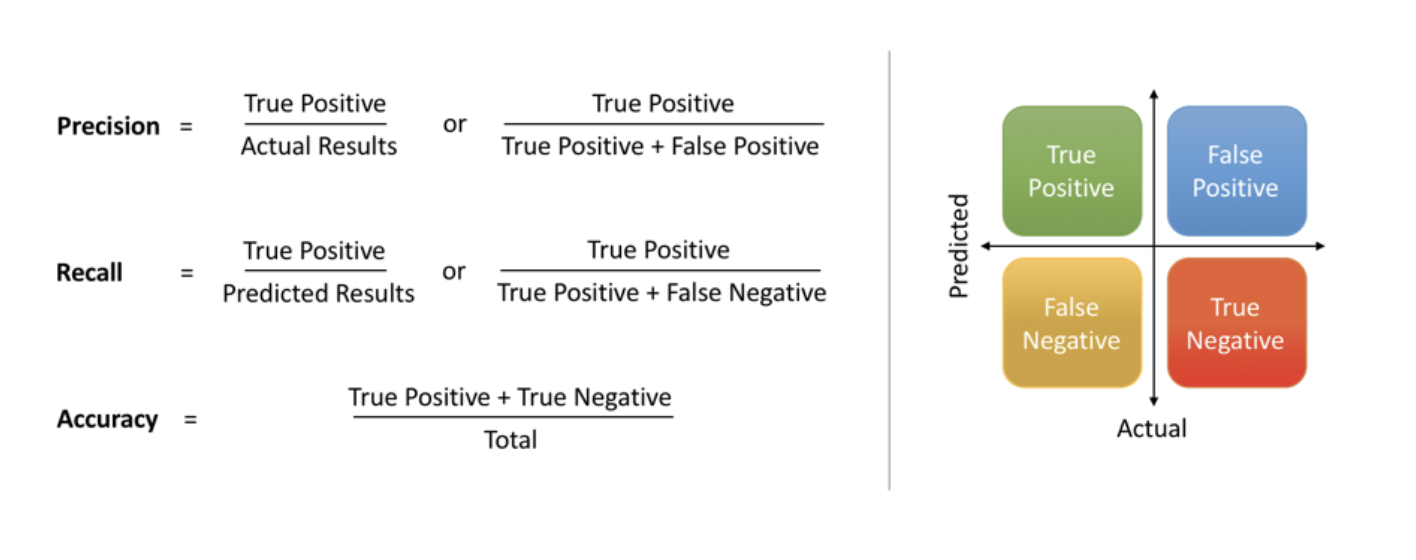

In [ ]:
Image(filename='/content/drive/Shareddrives/MGTF495/Lectures/Week_2/comparison.png')

In [ ]:
print ('precision = ' + str(round(metrics.precision_score(y_test, pred),4)))

precision = 0.5403


In [ ]:
print ('recall = ' + str(round(metrics.recall_score(y_test, pred),4)))

recall = 0.6204


$$ \text{F1 Score} = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [ ]:
print ('f1 score = ' + str(round(metrics.f1_score(y_test, pred),4)))

f1 score = 0.5776


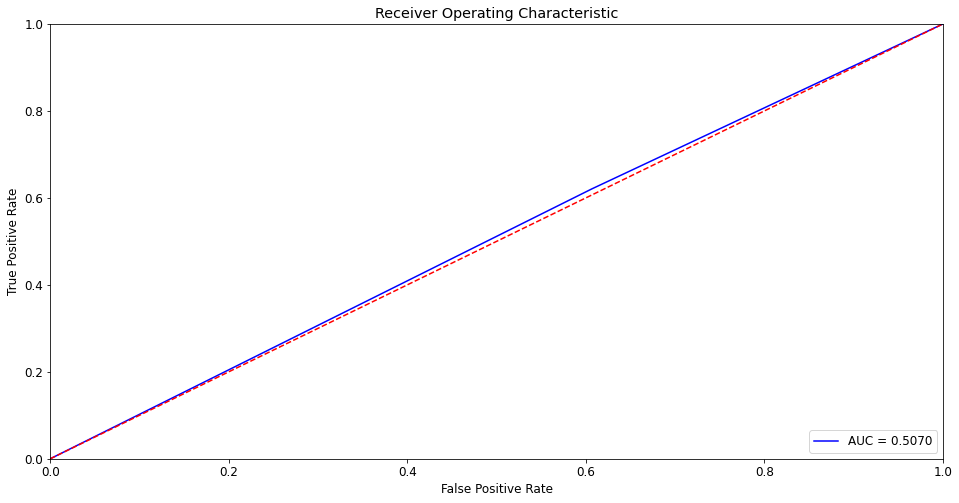

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=12)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Include, previous ROC curve